##    第1章　API周りの初期設定
---



**はじめに[Kaggle](https://www.kaggle.com/)のアカウントからAPIを使うためにjson持ってきて入れましょう**

In [0]:
from google.colab import files
files.upload()

{}

**jsonを入れれたらcolab上で使えるように権限を変えましょう**

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls -l /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

total 4
-rw------- 1 root root 62 Nov 14 06:03 kaggle.json


## 第2章　ライブラリの追加

---



今回はNNの定義にkerasを使うのでKerasを入れます。後は予測データを直接kaggleにアップするのでkaggleも入れます。

さらに追加でデータのNANを視覚化するためにmissingnoも入れます

In [0]:
!pip install keras
!pip install missingno
!pip install kaggle

**これでKaggleのAPIが使えるようになったので、早速 train/test データをダウンロードしましょう**

In [0]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 7.84MB/s]
  0% 0.00/89.2k [00:00<?, ?B/s]
100% 89.2k/89.2k [00:00<00:00, 51.0MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 77.6MB/s]
  0% 0.00/82.0k [00:00<?, ?B/s]
100% 82.0k/82.0k [00:00<00:00, 50.2MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 94.9MB/s]
  0% 0.00/15.3k [00:00<?, ?B/s]
100% 15.3k/15.3k [00:00<00:00, 16.3MB/s]
  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 29.2MB/s]


## 第3章　実際にやってみる
---

**最初にライブラリをインポートしましょう**

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from subprocess import check_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,Activation,Dropout
from keras.utils import np_utils
from keras.optimizers import SGD

**データをpandasで読み込み、少しだけ表示します。先程ダウンロードしたtrain / test データは content下にあります。**

In [0]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**次は次元のみを見ていきます。81個も、たくさんありますね**

In [0]:
df_train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


**流石に色々なタイプがあるのでobjectデータはラベルエンコードで綺麗にします**

In [0]:
from sklearn.preprocessing import LabelEncoder

for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtypes == object:
        lbl = LabelEncoder()
        lbl.fit(list(df_train.iloc[:,i].values) + list(df_test.iloc[:,i].values))
        
        df_train.iloc[:,i] = lbl.transform(list(df_train.iloc[:,i].values))
        df_test.iloc[:,i] = lbl.transform(list(df_test.iloc[:,i].values))

**train / testのIDを全体から取り除いて、値段を y_testとして取り出します**

ついでにNANの視覚化をします

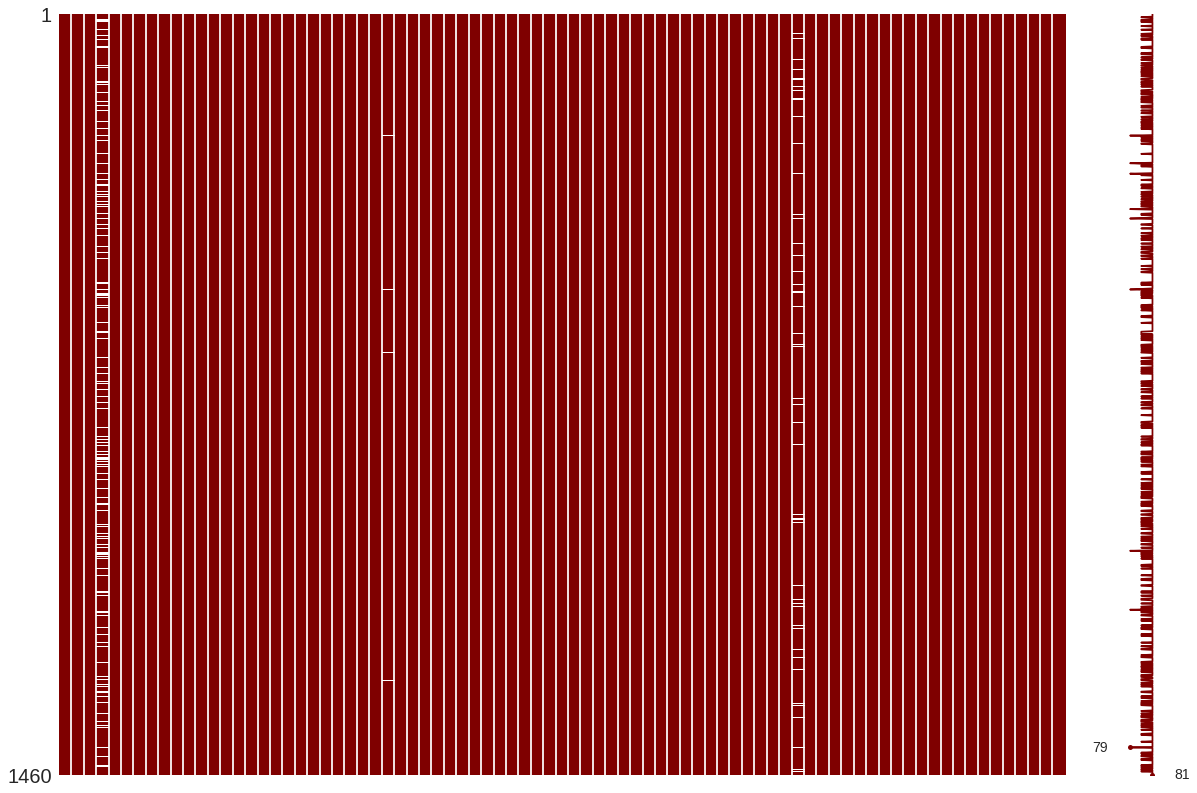

In [0]:
X_train = df_train.drop(['Id','SalePrice'], axis=1)
y_train = df_train['SalePrice']
X_test  = df_test.drop('Id', axis=1)

# search for missing data
import missingno as msno
msno.matrix(df=df_train, figsize=(20,14), color=(0.5,0,0))

**一部の多過ぎるNANを train / test の全体の中央値で埋めます**

In [0]:
# dealing with missing data
ntrain = X_train.shape[0]

Xmat = pd.concat([X_train, X_test])
Xmat['TotalSF'] = Xmat['TotalBsmtSF'] + Xmat['1stFlrSF'] + Xmat['2ndFlrSF']
Xmat = Xmat.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis=1)
Xmat = Xmat.fillna(Xmat.median())

**また、一番重要な値段の分布が正規分布に従っているか確認します**

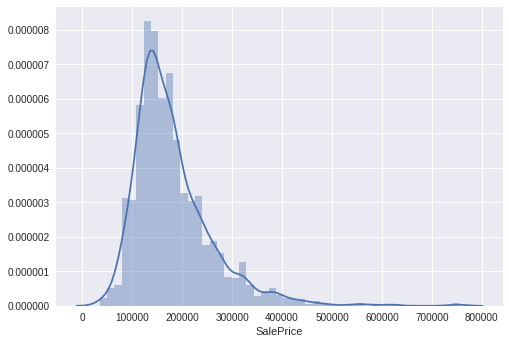

In [0]:
import seaborn
seaborn.distplot(y_train)

**従っていないので、少し綺麗にlogで処理します**

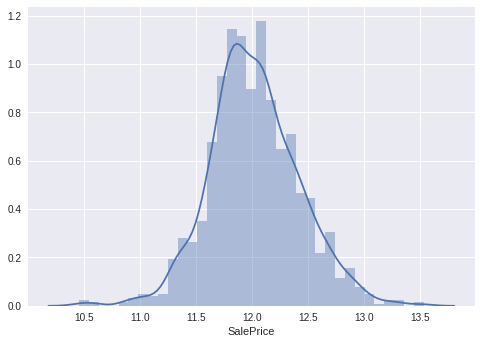

In [0]:
y_train = np.log(y_train)
seaborn.distplot(y_train)

**81次元のデータの中から、必要そうなラベルだけ取り出します。どれが大切なの..?**

ということで、ランダムフォレストでどれくらい寄与しているかを見ます

Training done using Random Forest


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


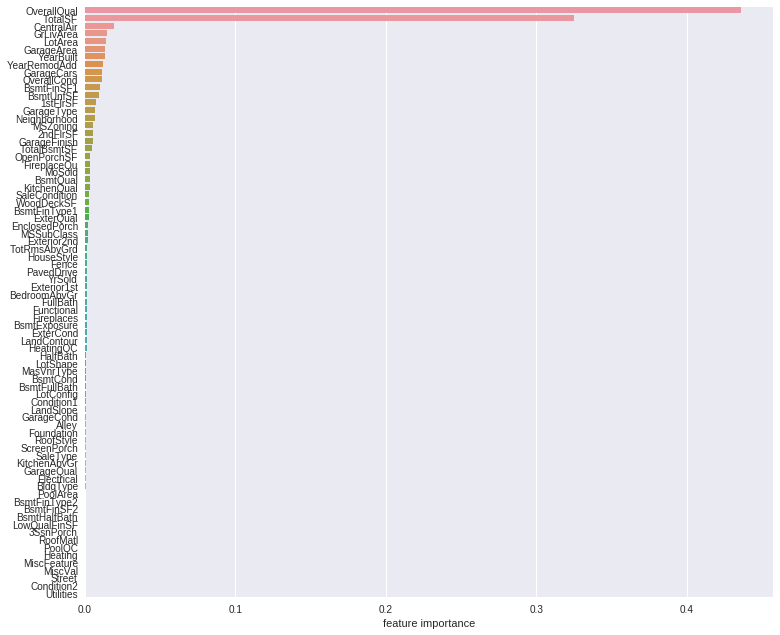

In [0]:
from sklearn.ensemble import RandomForestRegressor

X_train = Xmat[:ntrain]
X_test =  Xmat[ntrain:]

rf = RandomForestRegressor(n_estimators=80, max_features='auto')
rf.fit(X_train, y_train)
print('Training done using Random Forest')

ranking = np.argsort(-rf.feature_importances_)
f, ax = plt.subplots(figsize=(11, 9))
seaborn.barplot(x=rf.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

**上位数種が圧倒的すぎますね**

取り敢えずtop20を今回は使います。後、上位２種を掛け合わせたものも作ります。

In [0]:
X_train = X_train.iloc[:,ranking[:20]]
X_test = X_test.iloc[:,ranking[:20]]

X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

**一度、20種全体を相関にそっているのかプロットします**

OverallQualが綺麗ですね

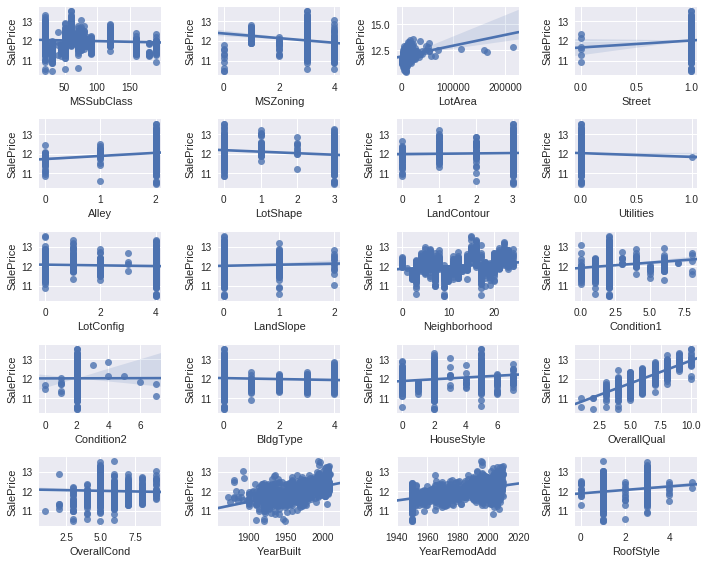

In [0]:
fig = plt.figure(figsize=(10,8))
for i in np.arange(20):
    ax = fig.add_subplot(5,4,i+1)
    seaborn.regplot(x=X_train.iloc[:,i], y=y_train)

plt.tight_layout()
plt.show()

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1],  activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 77)                6006      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                780       
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 11        
Total params: 6,797
Trainable params: 6,797
Non-trainable params: 0
_________________________________________________________________


**学習はじめます**

とりあえず150epoch

In [0]:
history = model.fit(X_train, y_train,  epochs=150, batch_size=32)

Epoch 1/150
1460/1460 [==============================] - 0s 245us/step - loss: 65146.9305
Epoch 2/150
1460/1460 [==============================] - 0s 41us/step - loss: 1302.7221
Epoch 3/150
1460/1460 [==============================] - 0s 40us/step - loss: 426.2230
Epoch 4/150
1460/1460 [==============================] - 0s 36us/step - loss: 353.9852
Epoch 5/150
1460/1460 [==============================] - 0s 41us/step - loss: 255.5357
Epoch 6/150
1460/1460 [==============================] - 0s 43us/step - loss: 208.4693
Epoch 7/150
1460/1460 [==============================] - 0s 41us/step - loss: 191.8969
Epoch 8/150
1460/1460 [==============================] - 0s 42us/step - loss: 157.0777
Epoch 9/150
1460/1460 [==============================] - 0s 42us/step - loss: 145.7743
Epoch 10/150
1460/1460 [==============================] - 0s 45us/step - loss: 118.4501
Epoch 11/150
1460/1460 [==============================] - 0s 44us/step - loss: 108.2828
Epoch 12/150
1460/1460 [=============

**acc / lossをグラフにプロットしてみる**

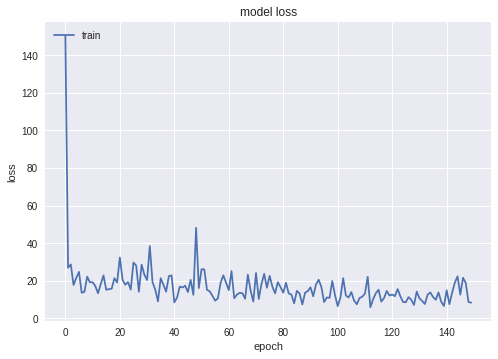

In [0]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: ignored

**テストデータに試してみる**

In [0]:
prediction = model.predict(X_test)



## 第4章　提出してみる


---


In [0]:
submission = pd.DataFrame()
id_col = df_test['Id'].values.tolist()
submission['Id'] = id_col
submission['SalePrice'] = prediction
submission.to_csv('house_submission.csv', index=False)
print(submission[0:10])


# submit the file to kaggle
!kaggle competitions submit house-prices-advanced-regression-techniques -f house_submission.csv -m "Complete!"

     Id   SalePrice
0  1461   27.314745
1  1462  189.037384
2  1463   27.064869
3  1464   29.351658
4  1465   34.841621
5  1466   27.614334
6  1467   34.591087
7  1468   27.721786
8  1469   32.256516
9  1470   28.496830
100% 20.9k/20.9k [00:01<00:00, 15.3kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques